### 本节课重点内容，搭建CNN网络，并完成cifar数据据集的分类任务。

#### CIFAR是由Alex Krizhevsky、Vinod Nair和Geoffrey Hinton收集而来，起初的数据集共分10类，
#### 分别为飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船、卡车，所以CIFAR数据集常以CIFAR-10命名。
#### 分为十个类别"airplane", "automobile", "bird", "cat","deer", "dog", "horse", "ship", "truck"用0-9表示
#### CIFAR共包含60000张32*32的彩色图像（包含50000张训练图片，10000张测试图片），
#### 其中没有任何类型重叠的情况


### 准备数据集，本地路径下有data_batch_1——data_batch_5是训练数据，test_batch包含的是测试数据集。

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import datasets

In [3]:
print(tf.__version__)

2.6.4


In [3]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from PIL import Image
import numpy as np

### 数据集获取，通常可以网络获取（如下语句），也可以本地获取，为了保证可用，我们准备了本地数据，并给出了读取该数据集的方法。

In [6]:
#(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()


### 本地读取数据集http://www.cs.toronto.edu/~kriz/cifar.html

In [5]:
#在给定数据文件中读取图片数据出来。
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#### 读取测试集一张图片认识存储方式

In [6]:
batch_dict=unpickle('cifar-10-batches-py/data_batch_1')#'读取测试图片数据'

In [7]:
print(batch_dict[b'data'].max())
test = batch_dict[b'data']#.astype('float')
test.shape

255


(10000, 3072)

### 观察上面的结果发现，测试集数据是1D数据，并不适合显示，因为我们把1D图像数据变成32，32，3的3D彩色图像，以便于显示。
### 由于我们观察到数据的值是整数，类型为uint8，可以使用imshow函数直接显示。

In [8]:
test_image = np.reshape(test[1], (3, 32, 32))
test_image = np.transpose(test_image,(1, 2, 0)) # 读取image

#### imshow函数显示RGB图像需要注意数据格式。
#### float类型数据，必须数据在0-1之间，int类型数据，必须数据在0-255之间
#### https://blog.csdn.net/applebear1123/article/details/120421817,图片显示空白的解决方案

In [9]:
print(test_image.max(),test_image.min())

254 5


(-0.5, 31.5, 31.5, -0.5)

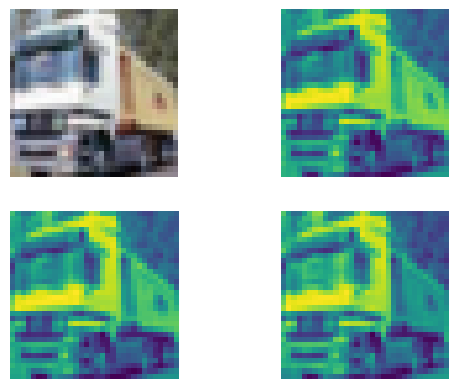

In [10]:
#显示一副测试图像
plt.figure()
plt.subplot(2,2,1)
plt.imshow(test_image.astype('uint8'))
plt.axis('off')


plt.subplot(2,2,2)
plt.imshow(test_image.astype('uint8')[:,:,0])
plt.axis('off')


plt.subplot(2,2,3)
plt.imshow(test_image.astype('uint8')[:,:,1])
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(test_image.astype('uint8')[:,:,2])
plt.axis('off')

#### 读取一张图片，认识RGB图像存储中，通常哪一个维度是R/G/B，观察可以看到在imshow函数中的数组存储格式为RGB---012的轴对应关系

In [12]:
img = Image.open('R-C.jpg')
re_img = np.array(img)
re_img.shape

(799, 1021, 3)

In [13]:
print(re_img.max())

255


(-0.5, 1020.5, 798.5, -0.5)

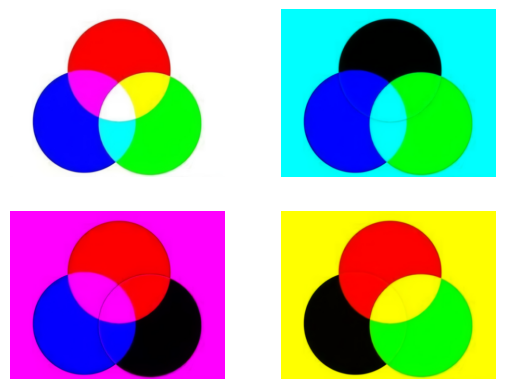

In [14]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(re_img)
plt.axis('off')

test_re_img1 = re_img.copy()#深度拷贝
test_re_img1[:,:,0] = 0#第一个通道赋值为0，通过显示图片，可以知道该通道时R通道
plt.subplot(2,2,2)
plt.imshow(test_re_img1)
plt.axis('off')

test_re_img2 = re_img.copy()
test_re_img2[:,:,1] = 0#第二个通道赋值为0，通过显示图片，可以知道该通道时G通道
plt.subplot(2,2,3)
plt.imshow(test_re_img2)
plt.axis('off')

test_re_img3 = re_img.copy()
test_re_img3[:,:,2] = 0#第三个通道赋值为0，通过显示图片，可以知道该通道时B通道
plt.subplot(2,2,4)
plt.imshow(test_re_img3)
plt.axis('off')

#### 总结：通过显示，我们可以看到一副图片通常o-r,1----g,2----b（通道---色彩通道）

#### 提示一下，我们上面代码，使用了copy函数，这是numpy的深度拷贝和浅拷贝。可以通过下面的代码查看两个变量是深度拷贝还是浅拷贝得到的

In [15]:
print(id(re_img),id(test_re_img3))#使用copy实现浅拷贝，没有copy是深度拷贝，两个变量存储id不一样，所以是深度拷贝。

2512193254960 2512197383920


In [17]:
#创建训练样本和测试样本
def CreatData():
    #创建训练样本
    #依次加载batch_data_i,并合并到x,y
    x=[]
    y=[]
    for i in range(1,6):
        batch_path='cifar-10-batches-py/data_batch_%d'%(i)##/kaggle/input/cifar10batchespy/##'cifar_dataset/data_batch_%d'%(i)
        print(batch_path)
        batch_dict=unpickle(batch_path)
        print("unzip")
        train_batch=batch_dict[b'data'].astype('float')
        train_labels=np.array(batch_dict[b'labels'])
        x.append(train_batch)
        y.append(train_labels)
    print("hello")
    #将5个训练样本batch合并为50000x3072，标签合并为50000x1
    #np.concatenate默认axis=0，为纵向连接
    traindata=np.concatenate(x)
    trainlabels=np.concatenate(y)
    
    #创建测试样本
    #直接写cifar-10-batches-py\test_batch会报错，因此把/t当作制表符了，应用\\;
    #    test_dict=unpickle("cifar-10-batches-py\\test_batch")
    
    #建议使用os.path.join()函数
    testpath=os.path.join('cifar-10-batches-py','test_batch')
    print(testpath)
    test_dict=unpickle(testpath)
    testdata=test_dict[b'data'].astype('float')
    testlabels=np.array(test_dict[b'labels'])

    return traindata,trainlabels,testdata,testlabels
traindata,trainlabels,testdata,testlabels = CreatData()

cifar-10-batches-py/data_batch_1
unzip
cifar-10-batches-py/data_batch_2
unzip
cifar-10-batches-py/data_batch_3
unzip
cifar-10-batches-py/data_batch_4
unzip
cifar-10-batches-py/data_batch_5
unzip
hello
cifar-10-batches-py\test_batch


In [18]:
print(traindata.max())#通过最大值可以看到图片数据的格式和最大值。以便于调整使用imshow显示
print('train size is :',traindata.shape)
print('train_labels size is :',trainlabels.shape)
print('test size is :',testdata.shape)
print('test_labels size is :',testlabels.shape)

255.0
train size is : (50000, 3072)
train_labels size is : (50000,)
test size is : (10000, 3072)
test_labels size is : (10000,)


### 提示：如果有数据超出内存的现象，可以考虑重新运行数据，很大可能是由于多次读取数据

#### 我们可以看到训练集里面有5万张，测试集有1万，大小是32x32x3.然后标签是一维数据

In [19]:
#合并数据集为了后面的乱序
train_test = np.concatenate((traindata,testdata),axis=0)
print(train_test.shape)
train_test_label = np.concatenate((trainlabels,testlabels),axis=0)
train_test_label.shape

(60000, 3072)


(60000,)

In [21]:
import sklearn as sk#打乱数组和标签的顺序
x,y = sk.utils.shuffle(train_test,train_test_label,random_state=1)

In [21]:
#停用下面的方法打乱数组顺序
#train_test_index = np.array(range(train_test.shape[0]))
#np.random.shuffle(train_test_index)
#train_test_shuffle = train_test.copy()
##train_test_label_shuffle = train_test_label.copy()
#for i in range(train_test.shape[0]):
   # temp_index = train_test_index[i]
    #train_test_shuffle[i] = train_test[temp_index]
    #train_test_label_shuffle[i] = train_test_label[temp_index]

#### 数据处理：1）归一化  2）one hot encoding

In [22]:
#数据归一化
x_guiyi = x.astype('float32')/255
#做one hot encoding
y_onehot = tf.keras.utils.to_categorical(y)

#### 在上面的test集读取，reshshape和显示的时候，我们注意到了:
#### 1.数据的存储矩阵为【3，32，32】，所以我们根据上面的操作，重新操作训练集。

In [23]:
x_images = np.reshape(x_guiyi, (x_guiyi.shape[0],3, 32, 32))

### 调整数组格式为50000，32，32，3.使用transpose函数，参考test数据集时候的矩阵转置方法。

In [24]:
x_images_images = np.transpose(x_images,(0,2,3,1)) # 读取image

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


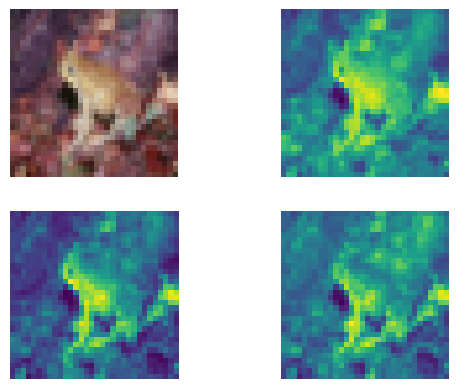

In [25]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(x_images_images[1])
plt.axis('off')


plt.subplot(2,2,2)
plt.imshow(x_images_images[1][:,:,0])
plt.axis('off')


plt.subplot(2,2,3)
plt.imshow(x_images_images[1][:,:,1])#(x_train_images[1].astype('uint8')[:,:,1])
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(x_images_images[1][:,:,2])
plt.axis('off')
print(y_onehot[1])

In [26]:
print(x_images_images.shape,y_onehot.shape)

(60000, 32, 32, 3) (60000, 10)


## 至此，我们的数据集如下：
### x_images_images----(60000, 32, 32, 3),取值范围0-1.
###        y_onehot----(60000,10)
### 为了减少模型运行时间以观察效果，我们做了两个事情，1）我们缩减了数据集，每个类别里面抽取300张图片。最终数据集为3000张图片。2）3D变2D灰度图像（可以不做）

In [27]:
## 学习list的基本操作
test_list = [[j for j in range(1)] for i in range(10)]
print(test_list)
print("----------------")
test_list[0].append(1)
print(test_list)
print("----------------")
test_list[0].pop()
print(test_list)
print("----------------")
test_list[0].pop()
print(test_list)
print("----------------")

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[0, 1], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------


In [28]:
def suojian(data,label, num):#data是需要被缩减的数据，label是对应data的标签，num是每个列别需要保留的个数
    class_label = [[j for j in range(1)] for i in range(10)]
    for i in range(10):
       # print(i)
        class_label[i].pop()#存储每个类别的索引
    for i in range(label.shape[0]):
        class_label[np.argmax(label[i])].append(i)
    #print(class_label)二维list，一维表示10个分类，一个维度记录着每个分类的图片所在下标
    #print(class_label[0][0:10])
    baoliu = []
    for i in range(10):
        temp = class_label[i][num:]
        #print(len(temp))
        baoliu.extend(temp)
    print(len(baoliu))
    #print(baoliu,len(baoliu))
    label1 =  np.delete(label,baoliu,axis=0)
    data1 = np.delete(data,baoliu,axis=0)
    x,y = sk.utils.shuffle(data1,label1,random_state=1)
    #print(data.shape,data1.shape)
    #print(label.shape,label1.shape)
    return x,y

In [29]:
suojian_x_images_images,suojian_y_onehot = suojian(x_images_images,y_onehot, 300)  #x_test_images,y_test #suojian(x_test_images,y_test, 5)
print('suojian totol images is :',suojian_x_images_images.shape)
print('suojian totol labels size is :',suojian_y_onehot.shape)

57000
suojian totol images is : (3000, 32, 32, 3)
suojian totol labels size is : (3000, 10)


### 拆分训练集/验证机/测试集，比例为8：1：1，也就是2400/300/300个。

In [30]:
# 观察过拟合现象.1)拆分数据集
def train_val_test(train_images,train_labels,ratio):
    num = train_images.shape[0] #总的数据集个数
    split_num_train = num - 2*round(num*ratio)
    split_num_val = num - round(num*ratio)
#拆分数据集和验证集
    train = train_images[:split_num_train]
    val = train_images[split_num_train:split_num_val]
    test = train_images[split_num_val:]
#拆分数据集和验证集标签    
    train_label = train_labels[:split_num_train]
    val_label = train_labels[split_num_train:split_num_val]
    test_label = train_labels[split_num_val:]

    return (train,train_label,val,val_label,test,test_label)

In [31]:

(sj_train,sj_train_label,sj_val,sj_val_label,sj_test,sj_test_label) = train_val_test(suojian_x_images_images,suojian_y_onehot,0.1)
print('suojian train images is :',sj_train.shape)
print('suojian train labels size is :',sj_train_label.shape)
print('suojian val images is :',sj_val.shape)
print('suojian val labels size is :',sj_val_label.shape)
print('suojian test images is :',sj_test.shape)
print('suojian test labels size is :',sj_test_label.shape)

suojian train images is : (2400, 32, 32, 3)
suojian train labels size is : (2400, 10)
suojian val images is : (300, 32, 32, 3)
suojian val labels size is : (300, 10)
suojian test images is : (300, 32, 32, 3)
suojian test labels size is : (300, 10)


### 彩色图像变灰度图像 L = R * 299/1000 + G * 587/1000+ B * 114/1000

In [32]:
### 为了提升运行速度，我们把数据集的唯彩色图像变成2d的灰度图像。
#def colorto2d(data):
    #data2d = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    ##print(data2d.shape)
    ##print(data.shape)
    #for i in range(data.shape[0]):
        #data2d[i] = data[i][:,:,0]*0.299 + data[i][:,:,1]*0.587 + data[i][:,:,2]*0.114
    #return data2d

In [33]:
#3d - --2d 转换函数调用代码，注释掉，可不用
#suojian_x_train_images_2d = colorto2d(suojian_x_train_images)
#suojian_x_test_images_2d = colorto2d(suojian_x_test_images)
#print('suojian 2d test size is :',suojian_x_train_images_2d.shape)
#print('suojian 2d test_labels size is :',suojian_x_test_images_2d.shape)

#### 数据处理：扩充3D数据以试用model输入，仅在3d--2d的时候使用

In [34]:
#扩维,以试用模型输入,彩色转换为2d以后需要此段代码扩维，如果是彩色图片，不需要此段代码扩围。可以临时注释掉
#suojian_x_train_images = np.expand_dims(suojian_x_train_images_2d,axis=3)
#suojian_x_test_images = np.expand_dims(suojian_x_test_images_2d,axis=3)
#print('suojian train size is :',suojian_x_train_images_2d.shape)
#print('suojian test size is :',suojian_x_test_images_2d.shape)
#print('suojian train label size is :',suojian_y_train.shape)
#print('suojian test_labels size is :',suojian_y_test.shape)

#### 搭建第一个CNN模型

In [34]:
input_shape = (32,32,3)
model = Sequential()
model.add(Conv2D(8, kernel_size=(5,5),activation='sigmoid',padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(16,kernel_size=(5,5),activation='sigmoid',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(units=10,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                1

In [35]:
model.compile(loss = 'mse', optimizer = optimizers.SGD(),metrics = ['accuracy'])  

In [36]:
print(sj_train.shape,sj_train_label.shape)

(2400, 32, 32, 3) (2400, 10)


In [37]:
model.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=1)

Epoch 1/10
600/600 [==============================] - 3s 3ms/step - loss: 0.0961 - accuracy: 0.0896
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0967
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0933
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0921
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0913
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0892
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.1029
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0954
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0896
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0933

In [38]:
model.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.0833


[0.09013103693723679, 0.0833333358168602]

### 可能他的效果并不好，但是我们还可以提升，现在你已经学会了搭建CNN网络，并把它训练，然后使用训练的模型预测结果。接下来搭建可以尝试完成作业了